In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os, json, h5py
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import h5py
import json

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory  = "./images_jpg", 
    color_mode = 'rgb',     
    batch_size = 32,
    image_size = (256, 256),  
    shuffle    = True,
    seed       = None,
    crop_to_aspect_ratio = False,
)

Found 1125 files belonging to 15 classes.


In [3]:
class_names = dataset.class_names
print(class_names)
sample_batch = dataset.take(1)
for image_batch, label_batch in sample_batch:
    print(image_batch.shape)
    print(label_batch.numpy())

['Brzoza', 'Buk', 'Dab', 'Jarzab', 'Jarzab_pospolity', 'Klon', 'Lipa', 'Olcha_szara', 'Topola', 'Topola_osika', 'Wiaz', 'Wiaz_gorski', 'Wierzba', 'Wierzba_biala', 'Wierzba_siwa']
(32, 256, 256, 3)
[ 8 10  7  9  2 13 11  4  0 13 14  8  5  4  4  1  7 12 14 11 10  7  8 10
  3  4  1  8 10  6  5  7]


In [4]:
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
# Normalizacja danych
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(dataset.class_names))  # liczba klas równa liczbie rodzajów liści
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
keras_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    #   callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
]

In [8]:
history = model.fit(normalized_train_dataset, epochs=10)

Epoch 1/10
28/28 [==============================] - 38s 1s/step - loss: 3.3416 - accuracy: 0.2121
Epoch 2/10
28/28 [==============================] - 39s 1s/step - loss: 0.9227 - accuracy: 0.7154
Epoch 3/10
28/28 [==============================] - 37s 1s/step - loss: 0.4189 - accuracy: 0.8817
Epoch 4/10
28/28 [==============================] - 33s 1s/step - loss: 0.2387 - accuracy: 0.9196
Epoch 5/10
28/28 [==============================] - 33s 1s/step - loss: 0.1265 - accuracy: 0.9542
Epoch 6/10
28/28 [==============================] - 34s 1s/step - loss: 0.0467 - accuracy: 0.9833
Epoch 7/10
28/28 [==============================] - 33s 1s/step - loss: 0.0398 - accuracy: 0.9866
Epoch 8/10
28/28 [==============================] - 33s 1s/step - loss: 0.0315 - accuracy: 0.9933
Epoch 9/10
28/28 [==============================] - 33s 1s/step - loss: 0.0383 - accuracy: 0.9933
Epoch 10/10
28/28 [==============================] - 33s 1s/step - loss: 0.0113 - accuracy: 0.9989


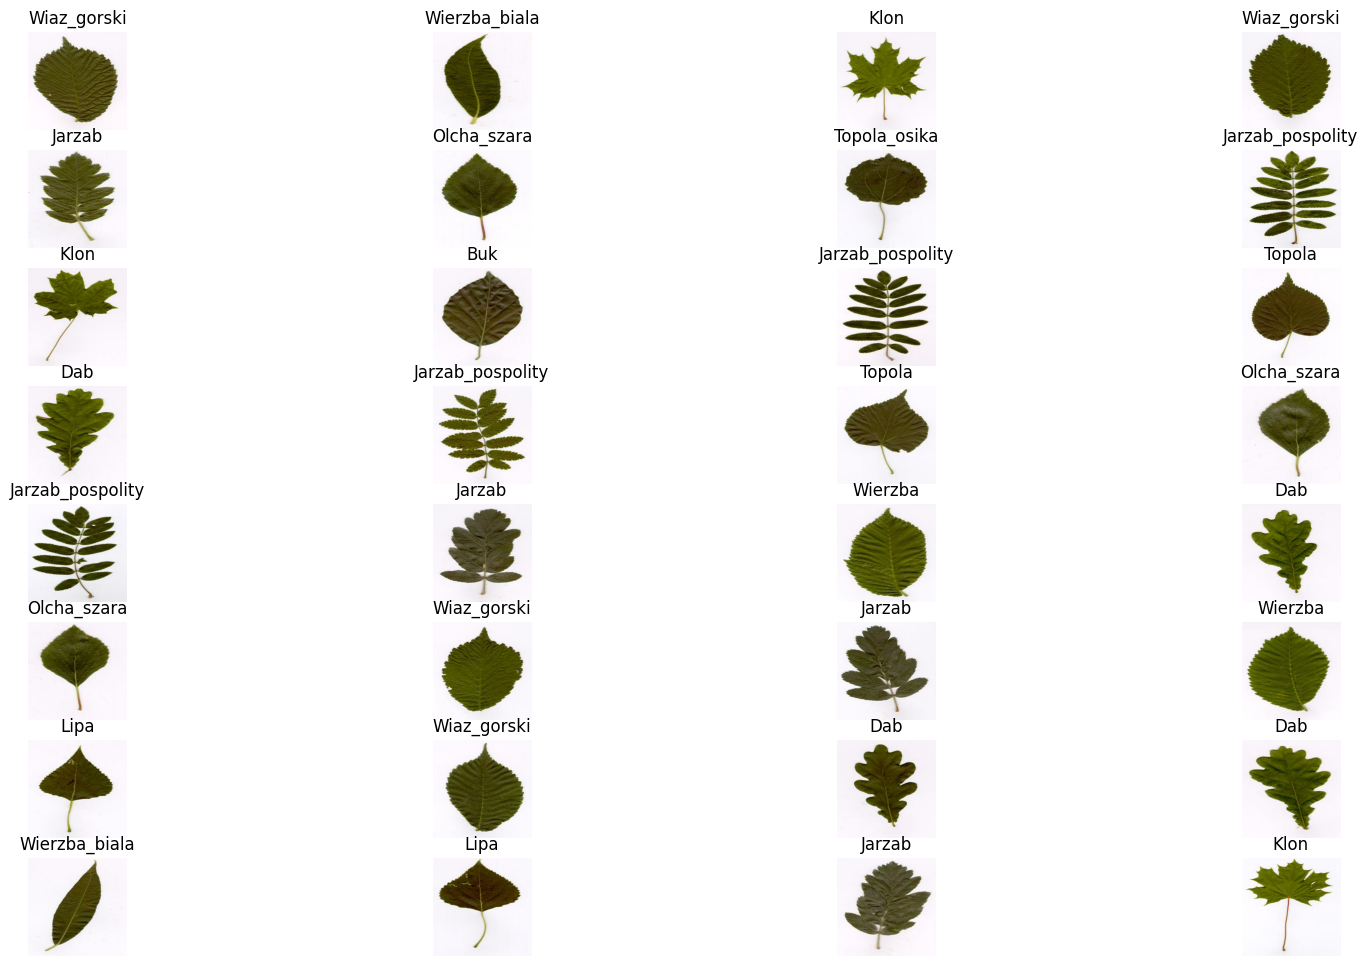

In [9]:
plt.figure(figsize=(20, 12))
for image_batch, label_batch in sample_batch:
    size = len(image_batch)
    columns = 4
    rows = size//columns
    for i in range(size):
        ax = plt.subplot(rows, columns, i + 1)   # rows, cols, idx
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # converting float to int
        plt.axis("off")

1/1 [==============================] - 0s 396ms/step


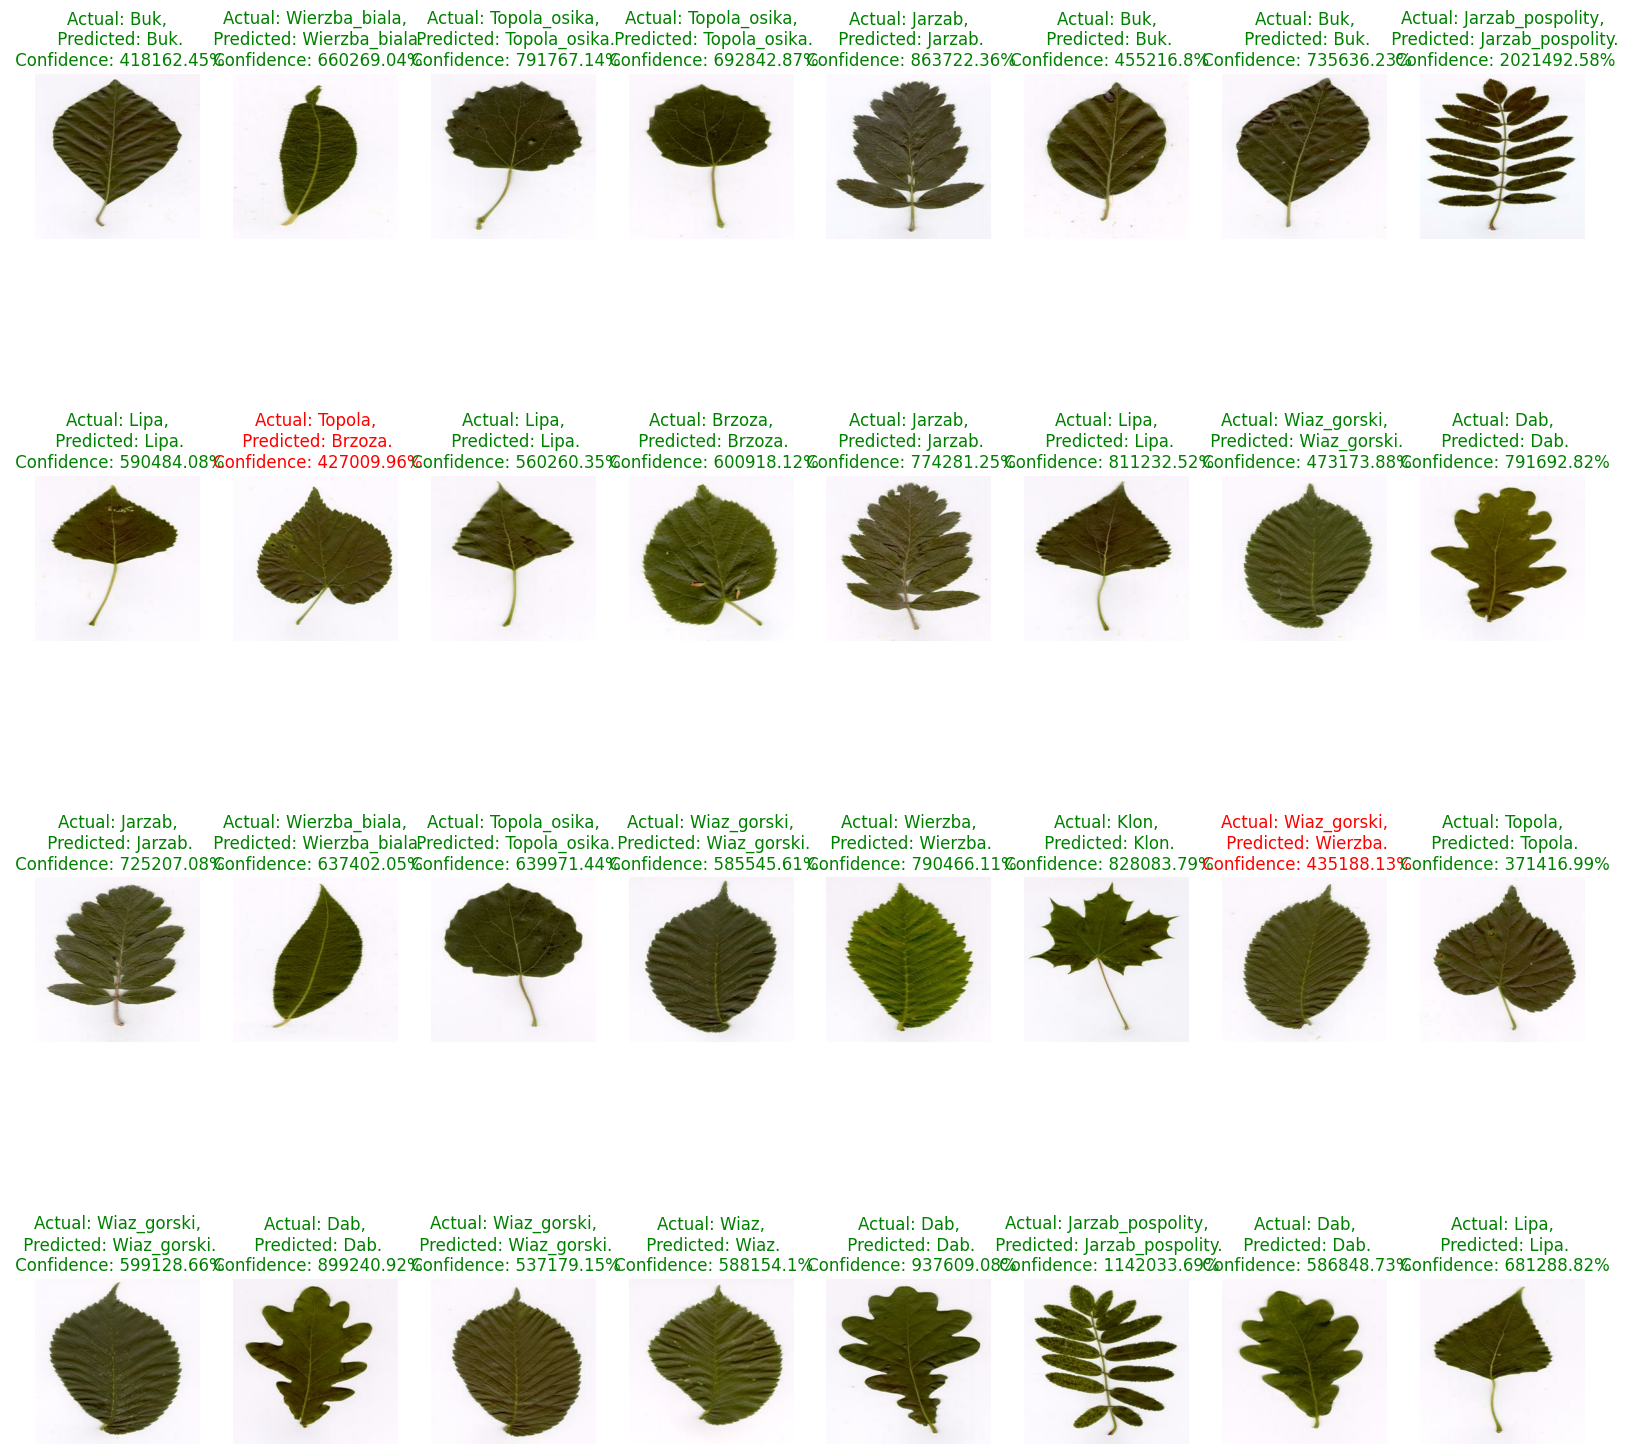

In [10]:
plt.figure(figsize=(20, 20))

# take a batch from 'test_ds'
for image_batch, label_batch in test_dataset.take(1):
    
    # returns array of confidences for different classes of all images in the batch
    prediction_batch = model.predict(image_batch)

    size = len(image_batch)
    columns = 8
    rows = (size + columns - 1) // columns  # Calculate the number of rows needed dynamically
    
    for i in range(size):
        
        image = image_batch[i].numpy().astype("uint8")   # converting float to int
        
        actual_class    = class_names[label_batch[i]]
        predicted_class = class_names[np.argmax(prediction_batch[i])]
        confidence      = round(100 * (np.max(prediction_batch[i])), 2)
        
        # Calculate the subplot index dynamically
        ax = plt.subplot(rows, columns, i + 1)   # row, col, idx

        title = plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.setp(title, color='g' if actual_class == predicted_class else 'r')
        plt.imshow(image)
        plt.axis("off")


In [11]:
model_path = "leaf_classifier.h5"
model.save(model_path)
with h5py.File(model_path,'r+') as fp:
  fp.attrs['class_names'] = json.dumps(class_names)

c:\Users\Micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model_path = "leaf_classifier.h5"
model = tf.keras.models.load_model(model_path)

In [13]:

with h5py.File(model_path,'r') as fp:
            class_names = json.loads(fp.attrs.get('class_names'))
print(class_names)
# Load the image
image_path = "test_images\Lisc_lipy.jpg"
image = tf.keras.utils.load_img(image_path)


['Brzoza', 'Buk', 'Dab', 'Jarzab', 'Jarzab_pospolity', 'Klon', 'Lipa', 'Olcha_szara', 'Topola', 'Topola_osika', 'Wiaz', 'Wiaz_gorski', 'Wierzba', 'Wierzba_biala', 'Wierzba_siwa']


In [41]:
image_path = "test_images\Buk_lisc_jesien.jpg"
image = tf.keras.utils.load_img(image_path)

In [42]:
target_size = (256, 256)
image = tf.image.resize(np.array(image), target_size)

In [43]:
input_arr = tf.keras.utils.img_to_array(image) / 255.0
input_arr = np.array([input_arr])  # Convert single image to a batch.

In [44]:
predictions = model.predict(input_arr) 
predicted_class = class_names[np.argmax(predictions)]
confidence = round(100 * (np.max(tf.nn.softmax(predictions))), 2)

1/1 [==============================] - 0s 37ms/step


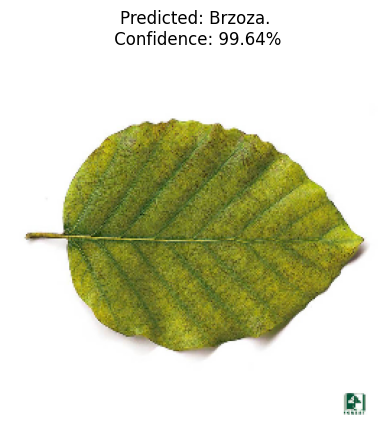

In [45]:
plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.imshow(input_arr[0])  # Display the normalized image
plt.axis("off")
plt.show()


In [19]:
model.summary()

# Get the list of layers in the model
layers_list = model.layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [20]:
for layer in layers_list:
    print(f"Layer: {layer.name}")
    weights = layer.get_weights()
    if weights:
        print(f"Number of weights: {len(weights)}")
        for i, weight_array in enumerate(weights):
            print(f"  Weight {i + 1} shape: {weight_array.shape}")
    else:
        print("No weights in this layer")
    print("\n")

    plt.figure(figsize=(20, 20))

Layer: conv2d
Number of weights: 2
  Weight 1 shape: (3, 3, 3, 32)
  Weight 2 shape: (32,)


Layer: max_pooling2d
No weights in this layer


Layer: conv2d_1
Number of weights: 2
  Weight 1 shape: (3, 3, 32, 64)
  Weight 2 shape: (64,)


Layer: max_pooling2d_1
No weights in this layer


Layer: conv2d_2
Number of weights: 2
  Weight 1 shape: (3, 3, 64, 64)
  Weight 2 shape: (64,)


Layer: flatten
No weights in this layer


Layer: dense
Number of weights: 2
  Weight 1 shape: (230400, 64)
  Weight 2 shape: (64,)


Layer: dense_1
Number of weights: 2
  Weight 1 shape: (64, 15)
  Weight 2 shape: (15,)




<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>